In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 5
macro_configs = config_generator(N_sample=[1000, 2000, 4000, 8000, 10000])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [83]:
#Network size
N = 2000
#Random connectivity
g = 40
#U = np.linalg.qr(np.random.normal(0, 1/np.sqrt(N), (N, N)))[0]
U = np.random.normal(0, 1/np.sqrt(N), (N, N))
c = 10
S = np.diag(c**2/np.arange(c, N+c)**2)
#S = np.diag(1 - np.arange(N)**4/N**4)
#S = np.diag(2 * N / (np.arange(1, N+1)**2) + np.sqrt(N))
#S = np.diag(1 - np.arange(N)/N)
#S = np.diag(10*np.exp(-0.1*np.arange(N)))
#VT = np.linalg.qr(np.random.normal(0, 1/np.sqrt(N), (N, N)))[0]
VT = np.random.normal(0, 1/np.sqrt(N), (N, N))
W = g * U.dot(S).dot(VT)
#W = g * U.dot(S).dot(U.T)
#W = g * np.random.normal(0, 1/np.sqrt(N), (N, N))                                                                                          

In [84]:
np.std(W) * np.sqrt(N)

1.7500373166222096

In [4]:
#Network size
#n_samples = 20
#N = 500
#R = 0.3
#shift = 5
#Ws = np.zeros((n_samples, 2*N, 2*N))
#r = np.random.uniform(0, R, N)
#theta = np.random.uniform(0, np.pi, N)
#for i in range(n_samples):
#    spec = shift + r*np.exp(theta*1j)
#    W = generate_real_matrix(spec)
#    Ws[i] = W

In [15]:
#N = 1000
#A = np.random.normal(0, 1, (N, N))
#Sigma = A.dot(A.T)
#x = np.random.multivariate_normal(np.zeros(N), Sigma, size=10000)

In [17]:
#cov = x.T.dot(x)/(x.shape[0] - 1)
#eigs, vecs = np.linalg.eig(cov)

Text(0, 0.5, 'Log var explained')

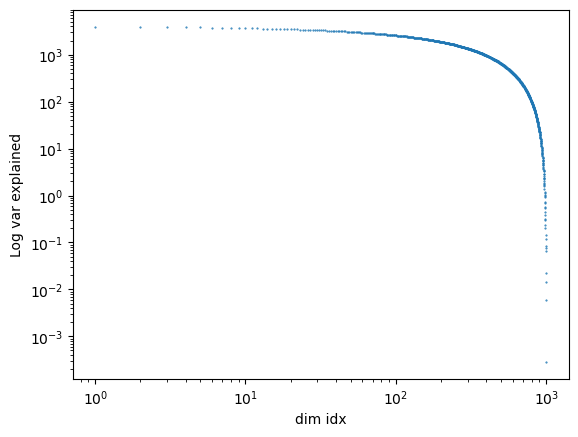

In [20]:
#plt.plot(sorted(np.abs(eigs))[::-1], '.', markersize=1)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('dim idx')
#plt.ylabel('Log var explained')

In [85]:
phi_numpy = lambda x: erf((np.sqrt(np.pi)/2)*x)
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime = lambda x: np.exp(-(np.pi/4)*x**2)
linear = True
if False:
    phi_numpy = lambda x: x
    phi_torch = lambda x: x
def run_sim(T_sim, T_eval, dt, W, N_batch=1):
    device = W.device
    N = W.shape[0]
    eval_iter = int(T_eval / dt)
    Nt = int(T_sim / dt)
    N_save = int(T_sim / T_eval)
    #define stuff
    x_save = torch.zeros(N_save, N_batch, N, device=device)
    x = torch.randn(N_batch, N, device=device) * torch.std(W).item() * np.sqrt(N)
    x_save[0] = x
    r_lpf = x.clone()
    r_lpf_save = torch.zeros_like(x_save)
    r_lpf_save[0] = r_lpf
    #run
    for i in range(1, Nt):
        r = phi_torch(x)
        r_lpf += dt*(-r_lpf + r)
        x += dt*(-x + torch.mm(r, W.T)) + torch.randn(size=r.shape, device=device)*np.sqrt(dt)
        if i % eval_iter == 0:
            x_save[i//eval_iter] = x
            r_lpf_save[i//eval_iter] = r_lpf
    return x_save, r_lpf_save

In [87]:
W_ = torch.from_numpy(W).type(torch.FloatTensor).to(0)
dt = 0.05
dt_save = 1
x_save, r_lpf_save = run_sim(10000, dt_save, dt, W_)

In [88]:
T_initial = 100
x = x_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
psi_emp = phi_prime(x).mean(1)
phi_lpf = r_lpf_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()

In [89]:
#r = phi_numpy(x)[:,:params['N_sample']]
r = phi_numpy(x)

In [90]:
cov = r.T.dot(r)/(r.shape[0] - 1)

In [19]:
#r_window = np.apply_along_axis(lambda m: np.convolve(m, np.ones(30)/30, mode='valid'), axis=0, arr=r)


In [91]:
eigs, vecs = np.linalg.eig(cov)

In [20]:
#cov_window = r_window.T.dot(r_window)/(r_window.shape[0] - 1)

In [21]:
#eigs, vecs = np.linalg.eig(cov_window)

In [10]:
#U, S_, VT = np.linalg.svd(W)

Text(0, 0.5, 'Log var explained')

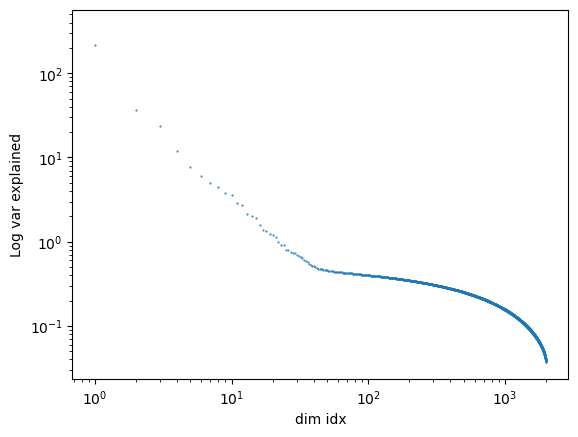

In [92]:
plt.plot(sorted(np.abs(eigs))[::-1], '.', markersize=1)
#plt.plot(np.diag(S_), '.', markersize=1)
#plt.plot(S_, '.', markersize=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dim idx')
plt.ylabel('Log var explained')

In [64]:
np.log(x+c).shape

(4000,)

Text(0, 0.5, '$\\lambda$')

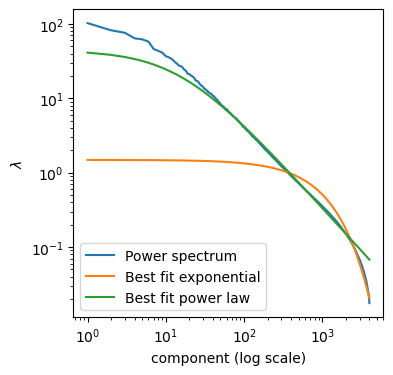

In [69]:
from scipy.stats import linregress
fig = plt.figure(figsize = (4, 4))
i = 3
N = 4000
s = np.array(sorted(np.abs(eigs))[::-1])
logs = np.log(s + 0.0001)
x = np.arange(1, len(s) + 1)
logx = np.log(x)
res = linregress(x, logs)
plt.plot(x, s)
plt.plot(x, np.exp(res.intercept) * np.exp(res.slope*x))
c = 15
res = linregress(np.log(x+c)[10:1000], logs[10:1000])
plt.plot(x, np.exp(res.intercept) * (x+c)**(res.slope))
plt.xscale('log')
plt.yscale('log')
plt.legend(['Power spectrum', 'Best fit exponential', 'Best fit power law'])
plt.xlabel('component (log scale)')
plt.ylabel('$\lambda$')
#fig.savefig('figs/spec_fits.pdf')

In [40]:
min_error = 10
min_res = None
min_c = 0
for c in np.arange(0, 1000, 1):
    res = linregress(np.log(x+c), logs)
    error = np.mean(np.square(np.exp(-(x+c))*(logs - (res.intercept + res.slope*np.log(x+c)))))
    if error < min_error:
        min_error = error
        min_res = res
        min_c = c

In [42]:
min_c

369

In [12]:
T, N = r.shape

In [13]:
F_train, G_train, F_test, G_test = r[:T//2,:N//2], r[:T//2,N//2:], r[T//2:,:N//2], r[T//2:,N//2:]

In [14]:
C = F_train.T.dot(G_train)/(T//2 - 1)
U, S, VT = np.linalg.svd(C)

In [15]:
Sk = np.array([U[:,k].dot(F_test.T).dot(G_test).dot(VT[k]) for k in range(N//2)])

In [16]:
Sktot = np.array([U[:,k].dot(F_test.T).dot(F_test).dot(U[:,k]) + VT[k].dot(G_test.T).dot(G_test).dot(VT[k])for k in range(N//2)])

In [17]:
percent_reliable_var = (Sk/(T//2)) / (Sktot / T)

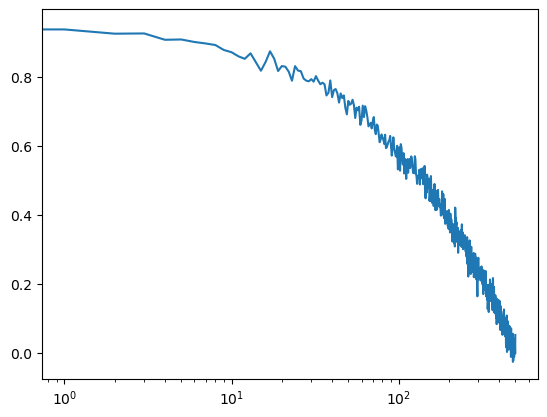

In [19]:
#plt.plot(percent_reliable_var)
#plt.xscale('log')
#plt.yscale('log')

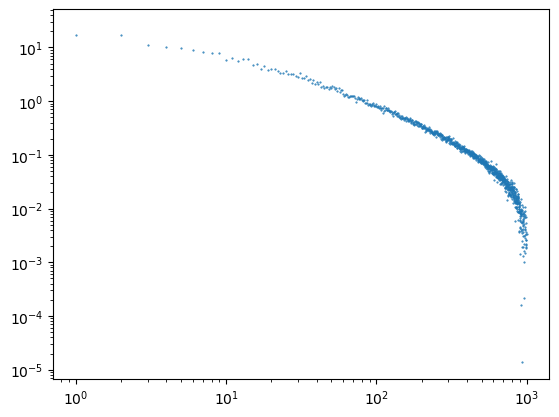

In [45]:
#plt.plot(Sk/(T//2), '.', markersize=1)
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
processed_data = np.zeros(10000)
#pd = np.array(sorted(np.abs(eigs))[::-1])
pd = percent_reliable_var
processed_data[:len(pd)] = pd

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [43]:
###Truncate file above
file_name = 'power_decay_torch_sims'
job_name = 'prv_sample_scaling_more_T'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook power_decay_torch_sims.ipynb to script
[NbConvertApp] Writing 12554 bytes to power_decay_torch_sims.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b46d32919d0> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b46d32919d0> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [44]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/prv_sample_scaling_more_T/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupyter_notebook.py
mft-theory/cluster/process_results.py
mft-theory/cluster/start_jupyter_notebook.py
mft-theory/cluster/submit_jobs.py
mft-theory/cluster/sync_cluster.py
mft-theory/core/
mft-theory/core/Simulation.py
mft-theory/core/Time_Cts_RNN.py
mft-theory/cor

In [6]:
job_id_1 = submit_job(job_script_path, n_jobs)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/spectrum_N_scaling/result_*’: No such file or directory
sending incremental file list

sent 1,419 bytes  received 28 bytes  2,894.00 bytes/sec
total size is 202,595  speedup is 140.01
sbatch  --exclude=ax[01-13],ax[17-19] --array=1-4 /home/om2382/low-rank-dims/job_scripts/spectrum_N_scaling.s


In [94]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           2810845    lkumar  jupyter   om2382  R      51:00      1 ax14


In [95]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'prv_sample_scaling_more_T'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [45]:
!ls -t ../job_scripts/

prv_sample_scaling_more_T.s	  s_vary_alignment_nm_decouple_full.s
prv_sample_scaling.s		  s_vary_alignment_nm_decouple.s
spectrum_N_sample_scaling.s	  s_vary_alignment.s
spectrum_N_scaling_2.s		  s_g_4_k.s
spectrum_N_scaling.s		  s_g_small_range_k_2.s
spectra_scaling_N_2.s		  s_g_small_range_k.s
R_shift_spectral_decays.s	  s_g_dim_no_subtract_big_data.s
g_spectral_decays_2.s		  s_g_dim_no_subtract.s
g_spectral_decays.s		  s_g_dim.s
spectra_scaling_N.s		  cov_stats_s_N.s
spectra_scaling.s		  cov_dist_s_N.s
pr_check_fuzzy_donut_3.s	  k_traj_vary_s_N.s
pr_check_fuzzy_donut_2.s	  cov_spectra_vary_s_N.s
pr_check_fuzzy_donut.s		  cov_spectra_vary_s.s
g_s_ratio_check.s		  proj_out_m1m2_smallN.s
noises_g_bifuraction.s		  donut_N_vary_more_data.s
kappaa_N_growth_2.s		  donut_N_vary.s
kappaa_N_growth.s		  reliable_donut.s
alignment_N_growth_gpu_2.s	  g_s_long_vary.s
alignment_N_growth_gpu.s	  n4k_g15g2_dims.s
delta_emp_gpu_test_2.s		  n2k_g1_20_dims.s
delta_emp_gpu_test.s		  n1k_dims.s
test_gpu.

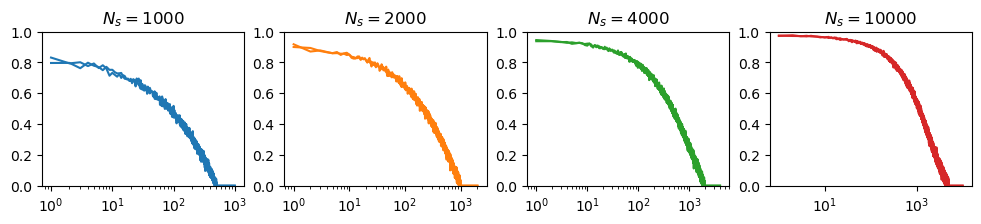

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(12, 2))
for i in range(4):
    N = configs_array['N_sample'][i]
    for j in [3, 4]:
        ax[i].plot(np.arange(1, N+1), results_array[i,j,:N], color='C{}'.format(i))
    ax[i].set_xscale('log')
    #ax[i].set_yscale('log')
    
    ax[i].set_ylim([0, 1])
    ax[i].set_title('$N_s = {}$'.format(N))

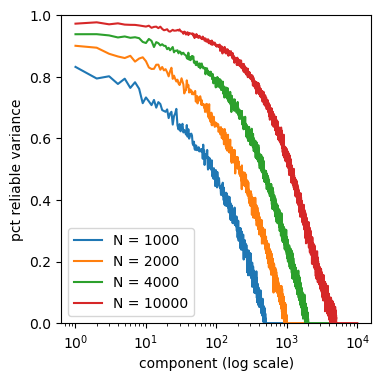

In [69]:
fig = plt.figure(figsize=(4, 4))
for i in range(4):
    N = configs_array['N_sample'][i]
    for j in [3]:
        plt.plot(np.arange(1, N+1), results_array[i,j,:N], color='C{}'.format(i))
    plt.xscale('log')
    plt.ylim([0, 1])
    plt.legend(['N = {}'.format(configs_array['N_sample'][i]) for i in range(4)])
    plt.xlabel('component (log scale)')
    plt.ylabel('pct reliable variance')
fig.savefig('figs/prv_N_more_T.pdf')

IndexError: list index out of range

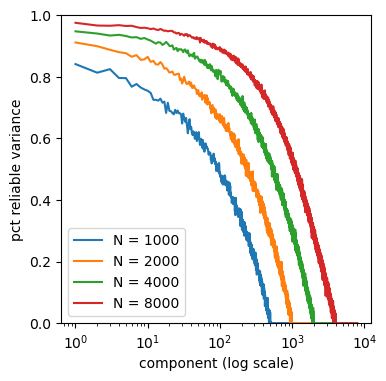

In [97]:
fig = plt.figure(figsize=(4, 4))
for i in range(4):
    N = configs_array['N_sample'][i]
    for j in [3]:
        plt.plot(np.arange(1, N+1), results_array[i,j,:N], color='C{}'.format(i))
    plt.xscale('log')
    plt.ylim([0, 1])
    plt.legend(['N = {}'.format(configs_array['N_sample'][i]) for i in range(4)])
    plt.xlabel('component (log scale)')
    plt.ylabel('pct reliable variance')
fig.savefig('figs/prv_N_more_T.pdf')

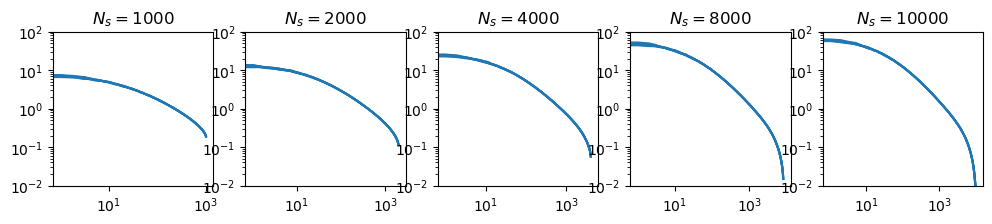

In [47]:
fig, ax = plt.subplots(1, 5, figsize=(12, 2))
for i in range(5):
    N = configs_array['N_sample'][i]
    for j in range(5):
        #ax[i].plot(np.arange(0, N), results_array[i,j,:N], color='C{}'.format(i))
        ax[i].plot(np.arange(0, N), results_array[i,j,:N], color='C0')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim([0.01, 100])
    ax[i].set_title('$N_s = {}$'.format(N))
fig.savefig('figs/sample_spec_scaling_2.pdf')

In [14]:
for i in range(5):
    for j in range(5):
        s = results_array[i,j]
        print(s.sum()**2 / np.square(s).sum() * 1/configs_array['N_sample'][i])

0.45517040720796037
0.463544365049732
0.4550168727227492
0.4548669168172239
0.4627763000101566
0.3010233314854749
0.2982687325439633
0.2998354967488592
0.2948278427154094
0.2975306109735548
0.1785128582876352
0.17870154443508432
0.176587232064282
0.1761381832869332
0.17526905407368407
0.09494826015755473
0.09687489445089671
0.09516900237745216
0.09529867806475686
0.09649384622795978
0.07807741752223596
0.07901367387056607
0.0770931764119305
0.07941409767427803
0.07909630065099692


In [55]:
from scipy.stats import linregress

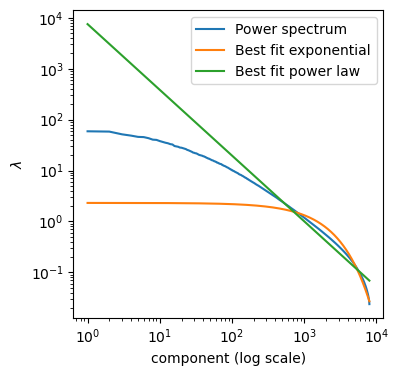

In [67]:
fig = plt.figure(figsize = (4, 4))
i = 3
N = configs_array['N'][i]
s = results_array[i, 0,:N]
logs = np.log(s + 0.0001)
x = np.arange(1, len(s) + 1)
logx = np.log(x)
res = linregress(x, logs)
plt.plot(x, s)
plt.plot(x, np.exp(res.intercept) * np.exp(res.slope*x))
res = linregress(logx, logs)
plt.plot(x, np.exp(res.intercept) * x**(res.slope))
plt.xscale('log')
plt.yscale('log')
plt.legend(['Power spectrum', 'Best fit exponential', 'Best fit power law'])
plt.xlabel('component (log scale)')
plt.ylabel('$\lambda$')
fig.savefig('figs/spec_fits.pdf')

In [17]:
res.slope * 

59.022911071777344

IndexError: list index out of range

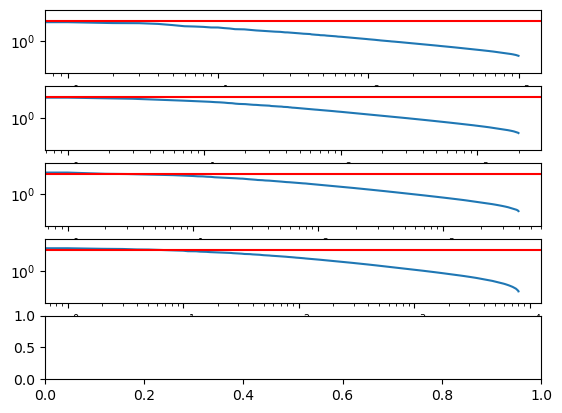

In [4]:
fig, ax = plt.subplots(5, 1)
for i in range(5):
    N = configs_array['N'][i]
    ax[i].plot(np.arange(0, N), results_array[i,0,:N], color='C0')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_ylim([0.003, 300])
    ax[i].axhline(y=40, color='r')

In [15]:
for i in range(4):
    N = configs_array['N'][i]
    spec = results_array[i,0,:N]
    PR = spec.sum()**2/(spec**2).sum() / N
    print(PR)

0.08881663777061949
0.07930433969081585
0.08213385858591697
0.06741682504032175


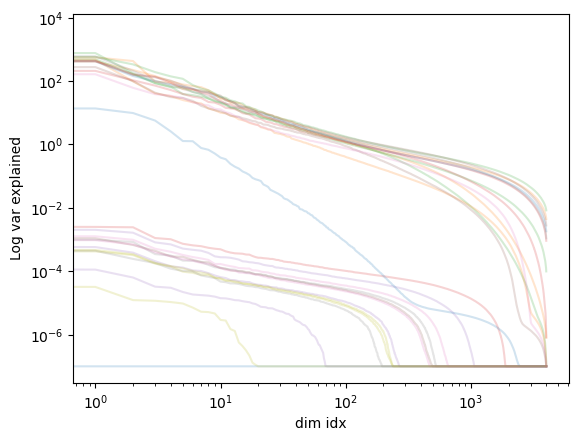

In [21]:
for i in range(3):
    for j in range(9):
        plt.plot(results_array[i,j,0,:] + 0.0000001, markersize=1, color='C{}'.format(j), alpha=0.2)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('dim idx')
        plt.ylabel('Log var explained')

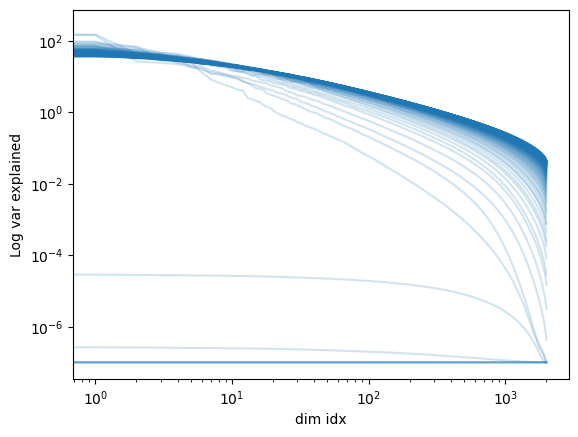

In [6]:
for i in range(195):
    plt.plot(results_array[i,0,:] + 0.0000001, markersize=1, color='C0', alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('dim idx')
    plt.ylabel('Log var explained')

In [ ]:
v = results_array.squeeze()
plt.plot(configs_array['g'], v[:,0])
plt.plot(configs_array['g'], v[:,1], '.')
plt.xlabel('g')
plt.ylabel('x noise')
plt.title('s = 2.6')

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 1
for i in range(5):
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp)], color='C2')
    #ax[i].set_xticks([])
    ax[i].set_yticks([0, 1])
    ax[i].set_ylim([0, 1])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 5
for i in range(5):
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 0], color='C1')
    ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 1], color='C1')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))
#plt.ylim([0, 1])

In [ ]:
time_emp = np.arange(0, 100, 0.5)
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
i_seed = 4
for i in range(5):
    ax[i].plot(results_array[i, i_seed, :len(time_emp), 0], results_array[i, i_seed, :len(time_emp), 1], color='C1')
    #ax[i].plot(time_emp, results_array[i, i_seed, :len(time_emp), 1], color='C1')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title('$N = {}$'.format(configs_array['N'][i]))
#plt.ylim([0, 1])

In [ ]:
mft = run_low_rank_dmft(g=3.8, s=2.6, T=50, dt=0.01)
Delta = mft['Delta']

In [ ]:
plt.imshow(Delta)

In [ ]:
time_emp = np.arange(0, 25, 0.5)
time_mft = np.arange(0, 25, 0.01)
fig = plt.figure()
plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=1)
plt.plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])

In [ ]:
time_emp = np.arange(0, 25, 0.5)
time_mft = np.arange(0, 25, 0.01)
fig = plt.figure()
for i in range(50):
    Delta_emp = results_array[i]
    plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.1)
plt.plot(time_emp, results_array.mean(0)[:len(time_emp)], color='C1')
plt.plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
#plt.xlim(-1, 50)
plt.ylim([-14, 14])
plt.xlabel('$t - s$')
plt.ylabel('$\Delta(t, s)$')
plt.title('$N = 20k, g=3.8, s=2.6$')
#fig.savefig('figs/N=2k_theory_sim.pdf', dpi=300)
#plt.show()
#plt.plot(time_emp, kappa_emp[:len(time_emp)])
#plt.figure()
#plt.plot(time_mft, mft['kappa'][:len(time_mft)])

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
time_emp = np.arange(0, 25, 0.05)
time_mft = np.arange(0, 25, 0.025)
D = np.amax(np.abs(results_array))
for i_g, g in enumerate(np.arange(3, 5, 0.4)):
    for i_s_, s in enumerate(np.arange(1, 3, 0.4)):
        i_s = 4 - i_s_
        mft = run_low_rank_dmft(g=g, s=s, T=50, dt=0.025)
        Delta = mft['Delta']
        for i_seed in range(40):
            Delta_emp = results_array[i_s_, i_g, i_seed]
            ax[i_s, i_g].plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.05)
        ax[i_s, i_g].plot(time_emp, results_array[i_s_, i_g].mean(0)[:len(time_emp)], color='C1', linewidth=2)
        ax[i_s, i_g].plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
        #ax[i_s, i_g].axis('off')
        ax[i_s, i_g].set_ylim([-D, D])
        ax[i_s, 0].set_ylabel('s = {:0.1f}'.format(s))
        ax[4, i_g].set_xlabel('g = {:0.1f}'.format(g))
fig.savefig('figs/theory_sim_g35_s13.pdf')